In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [81]:
import numpy as np
import pandas as pd

In [82]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [83]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [84]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base=automap_base()
Base.prepare(engine,reflect=True)

# reflect the tables


In [86]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [88]:
# Create our session (link) from Python to the DB
session=Session(engine)

# inspector

In [89]:
inspector=inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [90]:
columns=inspector.get_columns("Measurement")

for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [91]:
columns=inspector.get_columns("Station")

for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [92]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)


# Calculate the date 1 year ago from the last data point in the database
year_prior_date=dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_prior_date)



('2017-08-23',)
2016-08-23


2016-08-23


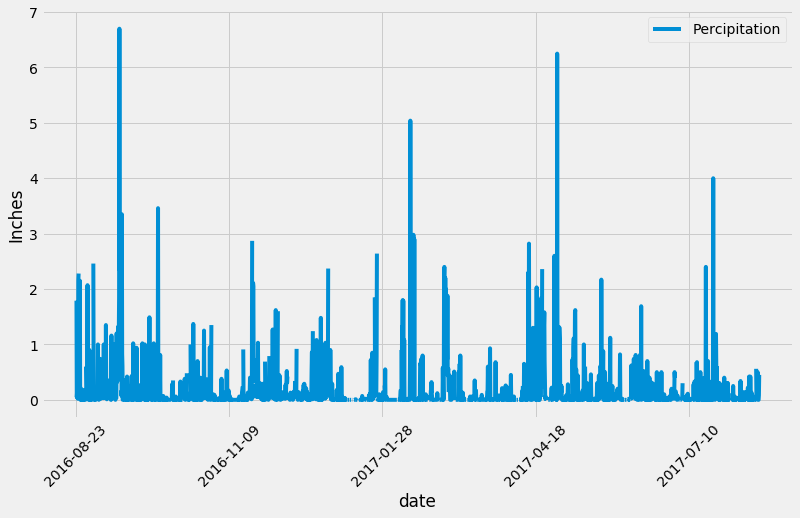

In [93]:

# Calculate the date 1 year ago from the last data point in the database
year_prior_date=dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_prior_date)
# Perform a query to retrieve the data and precipitation scores
year_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=year_prior_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

year_df=pd.DataFrame(year_data)

df_subset=year_df.set_index('date')
df_subset
# Sort the dataframe by date
sorted_df=df_subset.sort_values('date',ascending = True)
sorted_df.head()
# # Use Pandas Plotting with Matplotlib to plot the data

sorted_df.plot(figsize=(12,7),label="Precipitation",rot=45)
plt.legend(['Percipitation'],loc="upper right")
plt.ylabel('Inches')
plt.savefig("Resources/percipitation_plot.png")
plt.show()


In [94]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df=sorted_df.describe()
summary_df

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [95]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {station_count} stations in this dataset")


There are 9 stations in this dataset


In [96]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp=session.query(func.min(Measurement.tobs)).all()
highest_temp=session.query(func.max(Measurement.tobs)).all()
average_temp=session.query(func.avg(Measurement.tobs)).all()

print(f'lowest temperature recorded is {lowest_temp}')
print(f'highest temperature recorded is {highest_temp}')
print(f'highest temperature recorded is {average_temp}')

lowest temperature recorded is [(53.0,)]
highest temperature recorded is [(87.0,)]
highest temperature recorded is [(73.09795396419437,)]


In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active=session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()
most_active

('USC00519281', 2772)

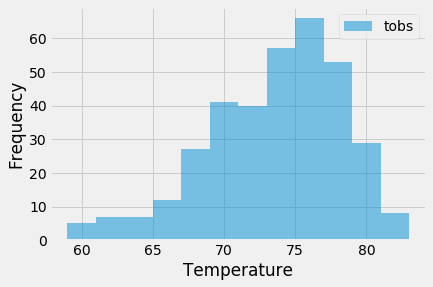

In [103]:
query=session.query(Measurement.station, Measurement.date, Measurement.tobs).\
            filter(Measurement.station=='USC00519281').\
            filter(Measurement.date <='2017-08-23').\
            filter(Measurement.date >= '2016-08-23').all()
df= pd.DataFrame(query)
df.rename(columns={"tobs": "temperature"})

df.plot.hist(bins=12, alpha=0.5)

plt.xlabel('Temperature')
plt.savefig("Resources/temp_observaion_plot.png")
plt.show()


In [104]:
from flask import Flask, jsonify

In [106]:
app = Flask(__name__)


@app.route("/api/v1.0/justice-league")
def justice_league():
    """Return the justice league data as json"""

    return jsonify(justice_league_members)


@app.route("/")
def welcome():
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation"
        f"/api/v1.0/stations"
        f"/api/v1.0/tobs"
        f"/api/v1.0/<start>"
        f"/api/v1.0/<start>/<end>")

## Bonus Challenge Assignment

In [79]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
